# Mini Proyecto : Aprendizaje Supervisado
**Inteligencia Artificial - Camila Sobrino - LIAN**

In [1]:
from IPython.core.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import multivariate_normal, norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

from warnings import filterwarnings
filterwarnings('ignore')

# Configuración de las figuras matplotlib
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams.update({'font.size': 12})

C:\Users\cvsob\AppData\Local\Temp\ipykernel_17940\561622218.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


### Ejercicio de aprendizaje supervisado (prediciendo mora)
Este conjunto de datos clasifica a las personas descritas por un conjunto de atributos como buenos o malos según su riesgo crediticio.

### Carga de datos
El dataset y su descripción se obtiene de la página:
 https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
 


In [2]:
def load_data():
  data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                     delimiter=" ",
                     header=None)
  data.columns=['existingchecking', 
                'duration', 
                'credithistory', 
                'purpose', 
                'creditamount', 
                'savings', 
                'employmentsince', 
                'installmentrate', 
                'statussex', 
                'otherdebtors', 
                'residencesince', 
                'property', 
                'age', 
                'otherinstallmentplans', 
                'housing', 
                'existingcredits', 
                'job', 
                'peopleliable', 
                'telephone', 
                'foreignworker', 
                'target'
                ]
  data.loc[:,'target'] = data['target'].replace([1,2],[1,0])
  return data

# Ejercicio 
---

Como parte del equipo de riesgos de una entidad financiera se le solicita utilizando la base de datos *german*, que desarrolle el mejor modelo que me permita clasificar a los clientes en riesgosos y no riesgosos desde el punto de vista de la probabilidad de caer en mora.

Para esto tenga en cuenta lo siguiente:

1) Realice un análisis explortorio tanto visual como formal y extraiga conclusiones 

2) Realice una preparación y preprocesado de los datos de acuerdo a lo observado. Por ej. analice nulos, outliers, codifique de forma adecuado las variables categóricas, analice el desbalanceo de clases, etc.

3) Compare las prestaciones en un conjunto de test de los siguientes clasificadores en términos de área bajo la curva ROC (AUC-ROC) y F1-score: 

- Regresión Logística con regularización L2, validando el parámetro $C$ de regularización.
- Random Forest validando tanto el número de estimadores y el máximo número de hojas.
- XGBoost validando el el número de estimadores, la máxima profundidad del arbol y learning_rate.
- Elija algún otro algoritmo si lo considera necesario


**En todos los casos, valide el número de variables a la entrada usando el criterio de información mútua y seleccione rangos de validación adecuados para cada hiperparámetro utilizando Gridsearch y Cross Validation. 
Y utilice Pipeline de sklearn para garantizar la ejecución ordenada de los distintos pasos

4) Represente también en una única gráfica la curva ROC de los cuatro clasificadores.

5) Recomiende el mejor clasificador y explique su elección


**Muestre, mediante gráficos y explicaciones acordes, las conclusiones a las que ha arribado durante y luego del aprendizaje.
Documente cada uno de los pasos del análisis para demostrar su entendimiento sobre el tema.**



# 1. EDA - Análisis explortorio tanto visual como formal y conclusiones 

---

In [3]:
data = load_data()
print("Cargadas {0:d} observaciones con {1:d} columnas\n".format(len(data), len(data.columns)))

Cargadas 1000 observaciones con 21 columnas



In [4]:
data.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   existingchecking       1000 non-null   object
 1   duration               1000 non-null   int64 
 2   credithistory          1000 non-null   object
 3   purpose                1000 non-null   object
 4   creditamount           1000 non-null   int64 
 5   savings                1000 non-null   object
 6   employmentsince        1000 non-null   object
 7   installmentrate        1000 non-null   int64 
 8   statussex              1000 non-null   object
 9   otherdebtors           1000 non-null   object
 10  residencesince         1000 non-null   int64 
 11  property               1000 non-null   object
 12  age                    1000 non-null   int64 
 13  otherinstallmentplans  1000 non-null   object
 14  housing                1000 non-null   object
 15  existingcredits       

### Información sobre el Dataset
El dataset contiene 1000 observaciones con 21 columnas de información sobre clientes y su propabilidad deriesgo de caer en mora. Según la iformacion, no contiene valores nulos en sus columnas-

Explicacion de cada una de las columnas:

- existingchecking: Indica el estado de la cuenta corriente del cliente.
    - "A11" (< 0 DM), "A12" (cuenta con saldo < 200 DM), "A13" (cuenta con saldo de 200 DM o más) y "A14" (sin cuenta bancaria)
- duration: Representa la duración del crédito en meses.
- credithistory: Describe el historial crediticio del cliente, que representan diferentes niveles de riesgo.
    -  A30: ningún crédito tomado/ todos los créditos pagados debidamente, A31 (todos los créditos en este banco pagados debidamente), A32 (créditos existentes pagados debidamente hasta ahora), A33 (retraso en el pago en el pasado), A33 (retraso en el pago en el pasado), A34 (cuenta crítica)
- purpose: Indica el propósito del crédito
    - A40:automóvil (nuevo), A41: automóvil (usado), A42:mobiliario/equipo, A43:radio/televisión, A44:electrodomésticos, A45:reparaciones, A46:educación, A47:(vacaciones - ¿no existe?), A48:reciclaje, A49:negocio, A410:otros
- creditamount: Es el monto del crédito solicitado en la moneda local.
- savings: Representa el estado de ahorros del cliente.
    - "A61" (< 100 DM), "A62" (<= 100 - < 500 DM), "A63" (<= 500 - < 1000 DM), "A64" (>= 1000 DM). "A65" (desconocido / si cuenta de ahorro)
- employmentsince: Indica el tiempo que el cliente ha estado empleado
    - "A71" (desempleado), "A72" (< 1), "A73" (1 <= ... < 4), "A74" (4 <= .... < 7), "A75" (>= 7)
- installmentrate: Es la tasa de la cuota en porcentaje del ingreso disponible.
- statussex: Combinación del estado civil y sexo del cliente
    - "A91" (hombre: divorciado/separado), "A92" (mujer:divorciado/separado/casado), "A93" (hombre: soltero), "A94" (hombre: casado/viudo), "A95" (mujer:soltera)
- otherdebtors: Indica si hay otros deudores o garantes
    - "A101" (ninguno), "A 102" (cosolicitante), "A103" (garante)
- property: Describe la propiedad del cliente
    - "A121" (bienes inmuebles), "A122" (si no A121: sociedad de ahorros acuerdo / seguro de vida), "A123" (si no A121/122: automóvil u otro), "A124" (desconocido/sin propiedad)
- age: Es la edad del cliente en años.
- otherinstallmentplans: Indica si hay otros planes de pago a plazos
    -  "A141" (banco), "A142" (tienda), "A143" (ninguno)
- housing: Muestra la situación de vivienda del cliente
    - "A151" (alquiler), "A152" (propio), "A153" (gratis)
- existingcredits: Es el número de créditos existentes que tiene el cliente.
- job: Describe el tipo de trabajo del cliente
    - "A171" (desempleado/no calificado), "A172" (no calificado-residente), "A173" (empleado calificado / funcionario), "A174" (gerente / autónomo/empleado altamente calificado/funcionario)
- peopleliable: Número de personas a cargo
- telephone: Indica si el cliente tiene teléfono
    - "A191" (no registrado), "A192" (si, registrado a nombre del cliente) 
- foreignworker: Indica si el cliente es un trabajador extranjero
    -  "A201" (si), "A202" (no)
- target: Es la variable objetivo, bueno (1) o malo (0) en terminos crediticios.

### Tipos de Variables:

In [6]:
data.describe(include = [object])

,existingchecking,credithistory,purpose,savings,employmentsince,statussex,otherdebtors,property,otherinstallmentplans,housing,job,telephone,foreignworker
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,A14,A32,A43,A61,A73,A93,A101,A123,A143,A152,A173,A191,A201
freq,394,530,280,603,339,548,907,332,814,713,630,596,963


In [7]:
data.describe(include = [np.number])

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.700000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


**Variables Categóricas:**

- Existingchecking: la gran mayoría de las personas en este dataset (394 registros) no tienen cuenta corriente (A14)
- credithistory: La categoría A32 es la más frecuente (530 de 1000), indicando que una buena parte de los clientes tiene una buena historia crediticia.
- savings: La categoría A61 predomina con 603 casos, lo que podría sugerir que una gran parte de los clientes tiene pocos o ningún ahorro.
- foreignworker: Hay una clara mayoría en A201 (963 de 1000), lo que podría sugerir que la mayoría de los clientes son trabajadores extranjeros.

**Variables Numéricas:**

- duration: La duración promedio del crédito es de aproximadamente 20.9 meses, con una desviación estándar de 12.05 meses. Esto indica que la duración de los créditos varía bastante.
- creditamount: El monto promedio de crédito es de 3271.26, con una desviación estándar considerable de 2822.74. Esto sugiere que los montos de crédito otorgados son muy variados.
- age: La edad promedio es de 35.55 años, lo que indica que la mayoría de los clientes se encuentran en una etapa adulta.
- existingcredits: La mayoría de los clientes tiene un crédito existente (media de 1.4), lo que indica que es común que los clientes tengan otros créditos.
- peopleliable: La mayoría de los clientes tiene a una persona a su cargo (media de 1.15).


### Análisis visual de variables y distribuciones.

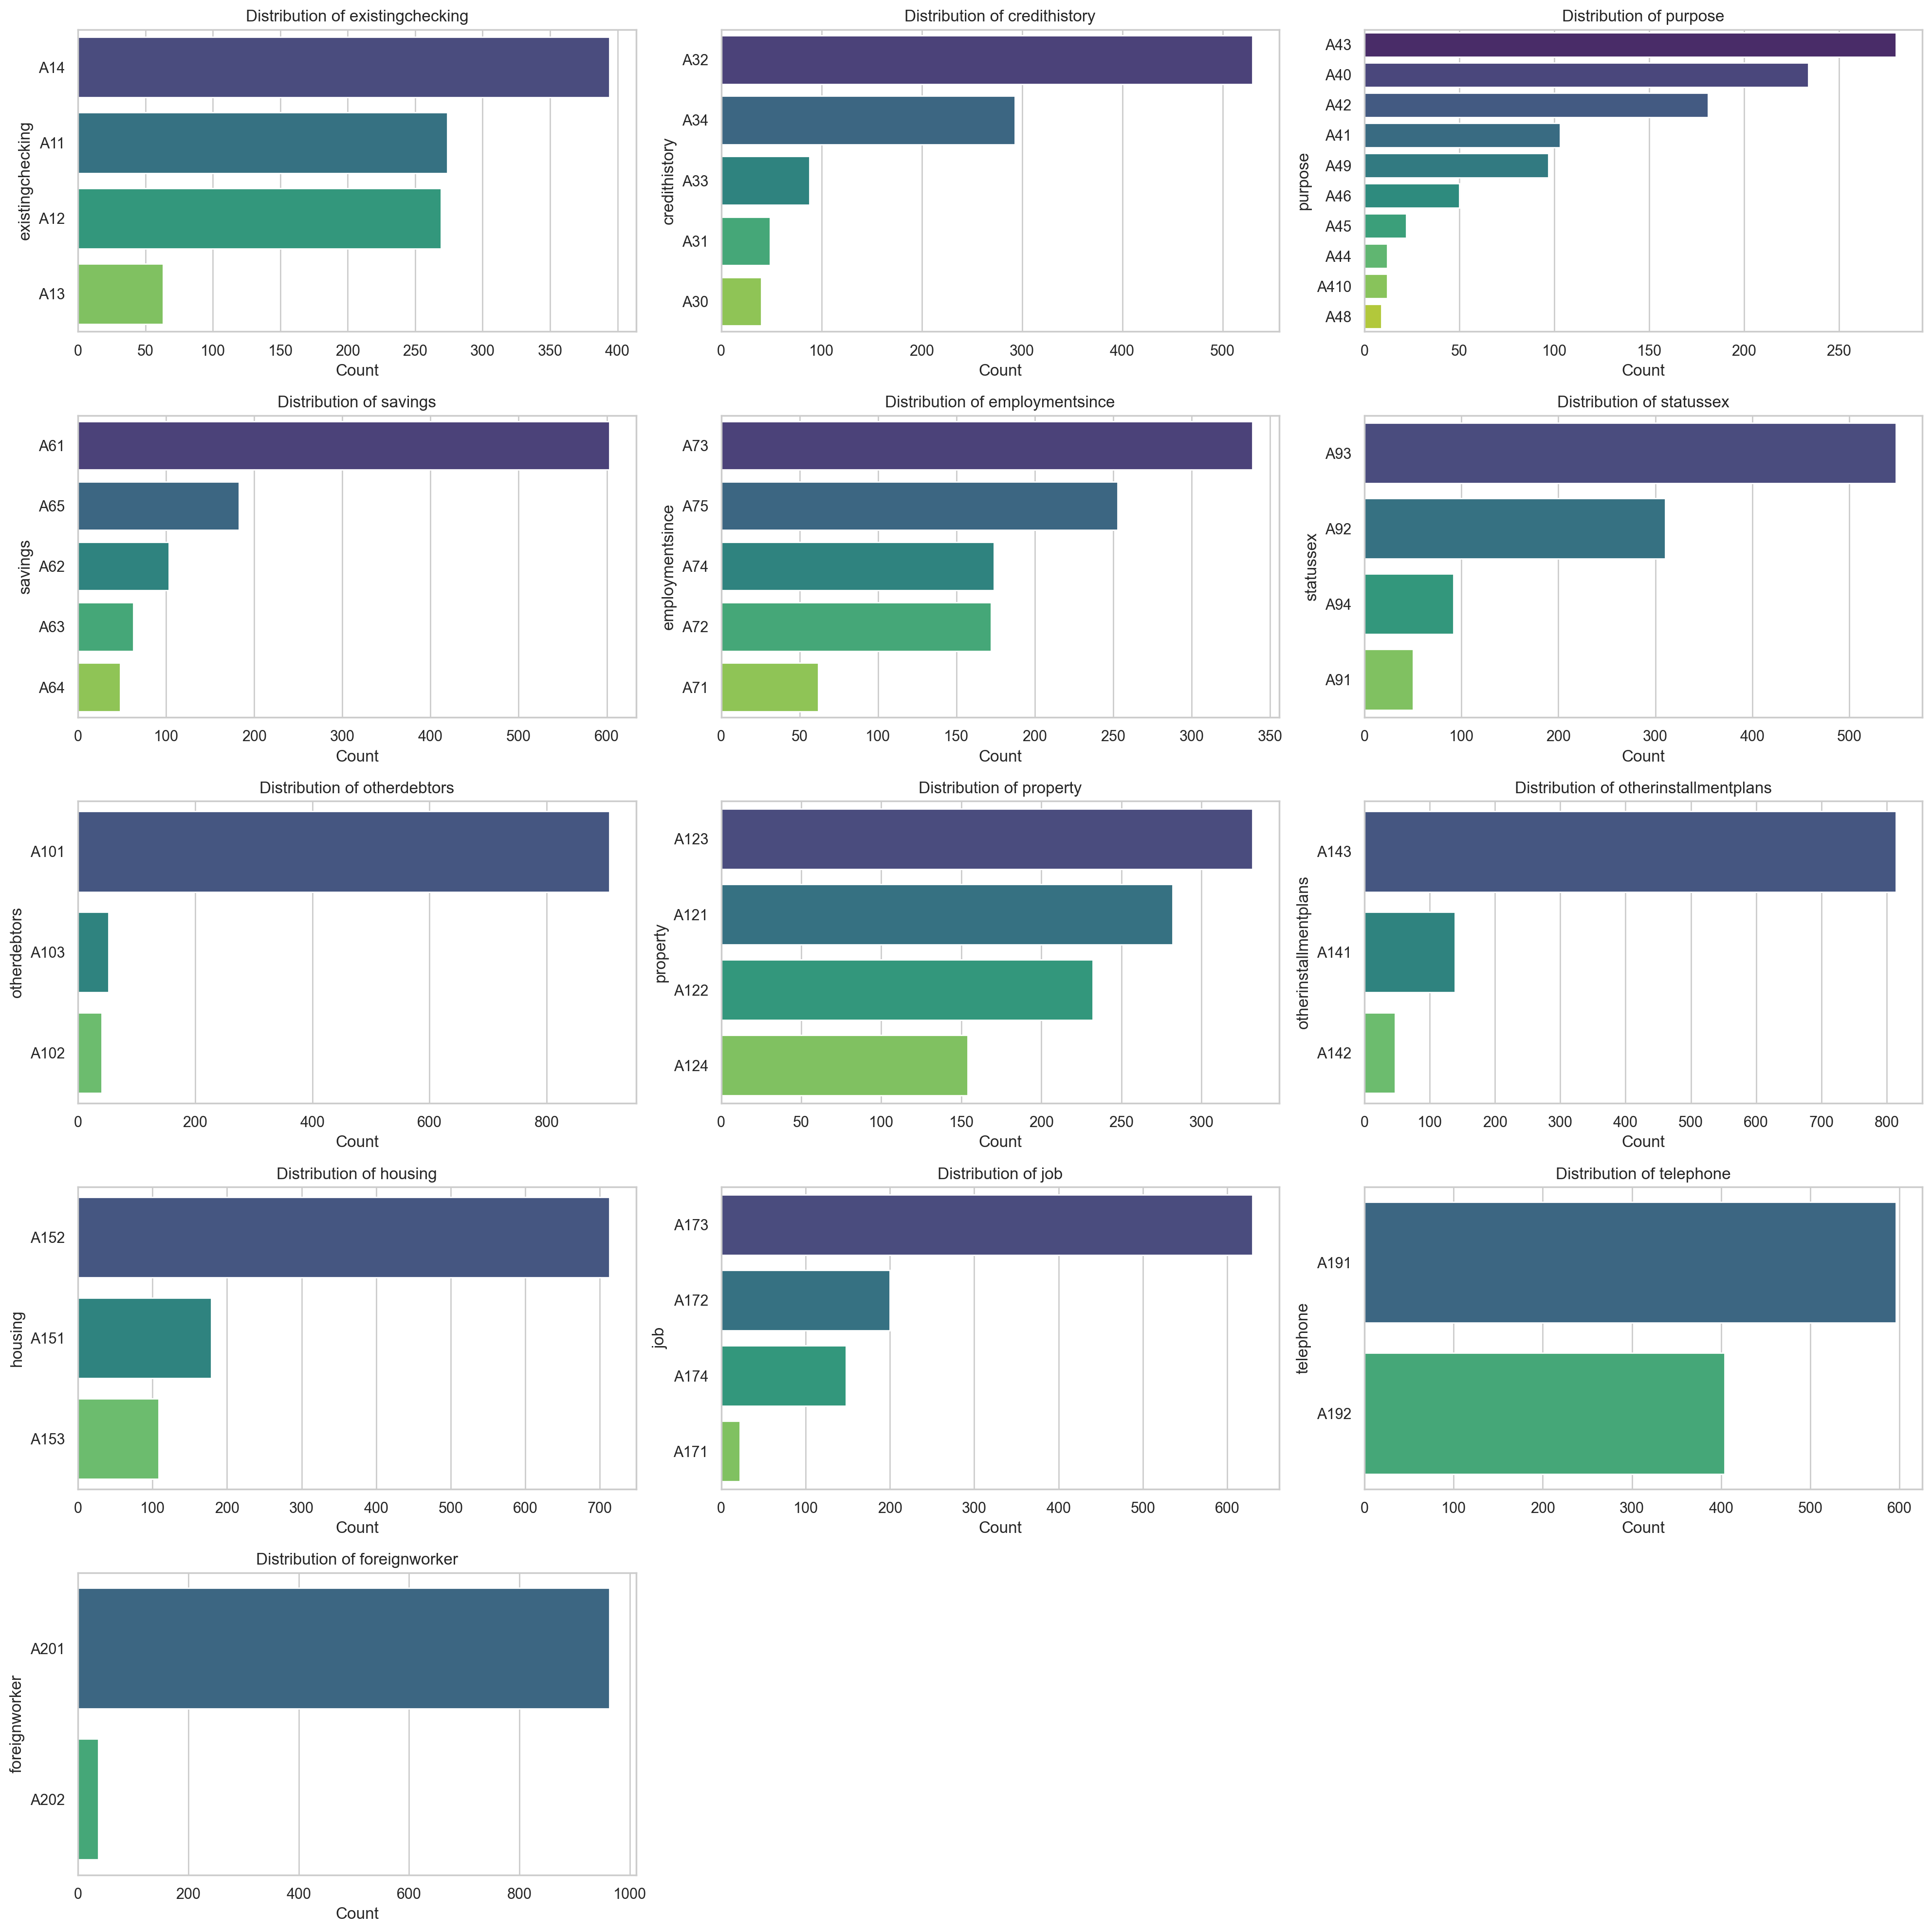

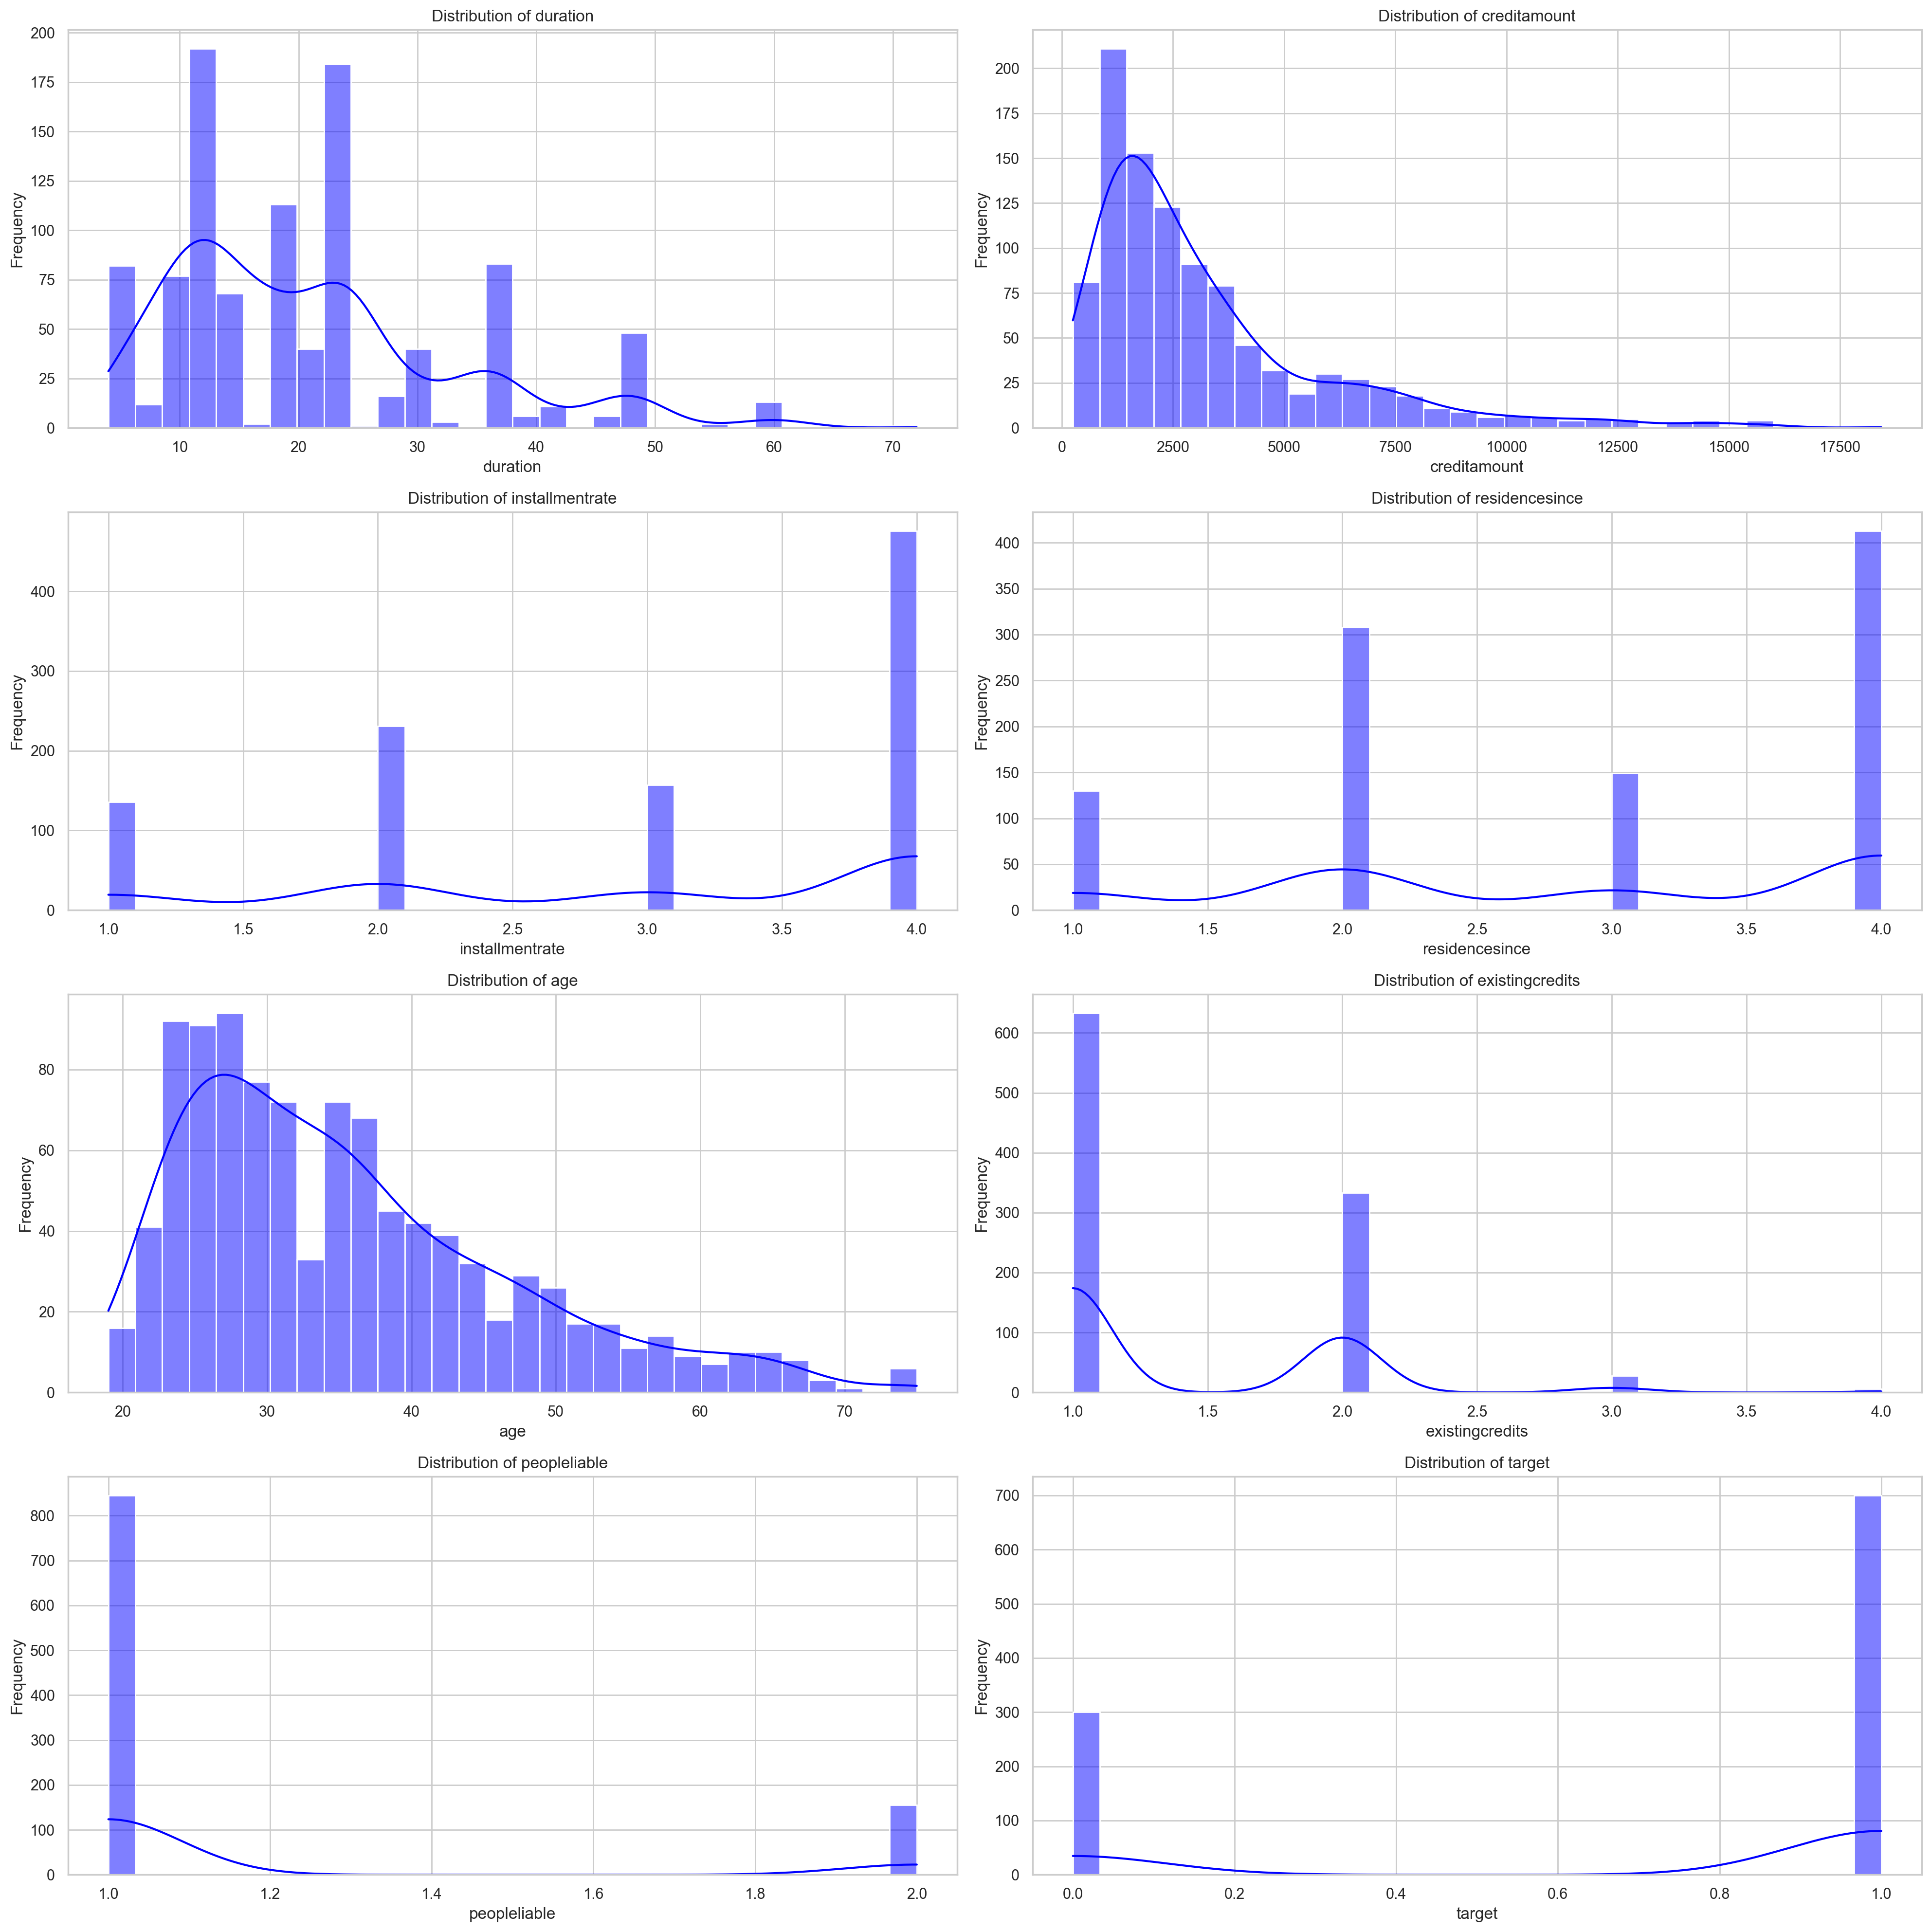

In [8]:
sns.set(style="whitegrid")

# Variables categóricas
categorical_vars = ['existingchecking', 'credithistory', 'purpose', 'savings',
                    'employmentsince', 'statussex', 'otherdebtors', 'property',
                    'otherinstallmentplans', 'housing', 'job', 'telephone', 'foreignworker']

# Variables numéricas
numerical_vars = ['duration', 'creditamount', 'installmentrate', 'residencesince', 
                  'age', 'existingcredits', 'peopleliable', 'target']

# Gráfico de variables categóricas
plt.figure(figsize=(20, 20))
for i, var in enumerate(categorical_vars):
    plt.subplot(5, 3, i+1)
    sns.countplot(y=data[var], order=data[var].value_counts().index, palette='viridis')
    plt.title(f'Distribution of {var}')
    plt.xlabel('Count')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

# Gráfico de variables numéricas
plt.figure(figsize=(20, 20))
for i, var in enumerate(numerical_vars):
    plt.subplot(4, 2, i+1)
    sns.histplot(data[var], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Según lo graficado podemos interpretar:
- purpose: las personas solicitan un credito mayormente para la categoria A43 (radio/television), A40(automovil) y A42 (mobiliario/equipo) mayormente.
- savings: mayormente A61 que implica una cuenta de ahorro < a 100DM.
- employmentsince: mayormente A73 que implica el tiempo de 1 - 4 años que esta empleado el cliente.
- statussex:mayormente hombre soltero (A93), seguido por mujeres divorciadas/separadas/casadas.
- otherdebtors: la mayoría (A101) de los préstamos no tienen otros deudores o garantes
- property: mayoría de las personas cuentan con un automóvil como propiedad
- housing: la mayoría de las personas  viven en un apartamento o casa alquilada, seguido de las personas que viven en una casa propia. Un número menor de personas no tienen vivienda.
- job: la mayor parte de las personas son empleados calificados / funcionario, seguido por una proporción de personas no calificadas (en menor medida)
- telephone: la mayoría de las personas no cuentan con registro a su nombre
- foreign worker: casi la totalidad son trabajadores extranjeros

- duration: la curva tiende hacia la izquierda representando un tiempo corto de la duracion del prestamo, encontrandose entre los 12 y 24 meses.
- creditamount: los montos en su mayoria son menores a 2500
- installmentrate: tasa de amortizacion mayoria del 4%
- age: distribucion homogenea centrada entre los 20 y 40 años
- existing credits:la mayoria se ubica entre 1 y 2 creditos 
- people liable: la gran mayoria presenta al menos 1 persona a cargo
- target: 700 personas son target 1 por lo cual se entiende que podran pagar el credito que soliciten. Solo 300 personas de nuestro dataset no podran pagar el prestamo en el caso de que soliciten.

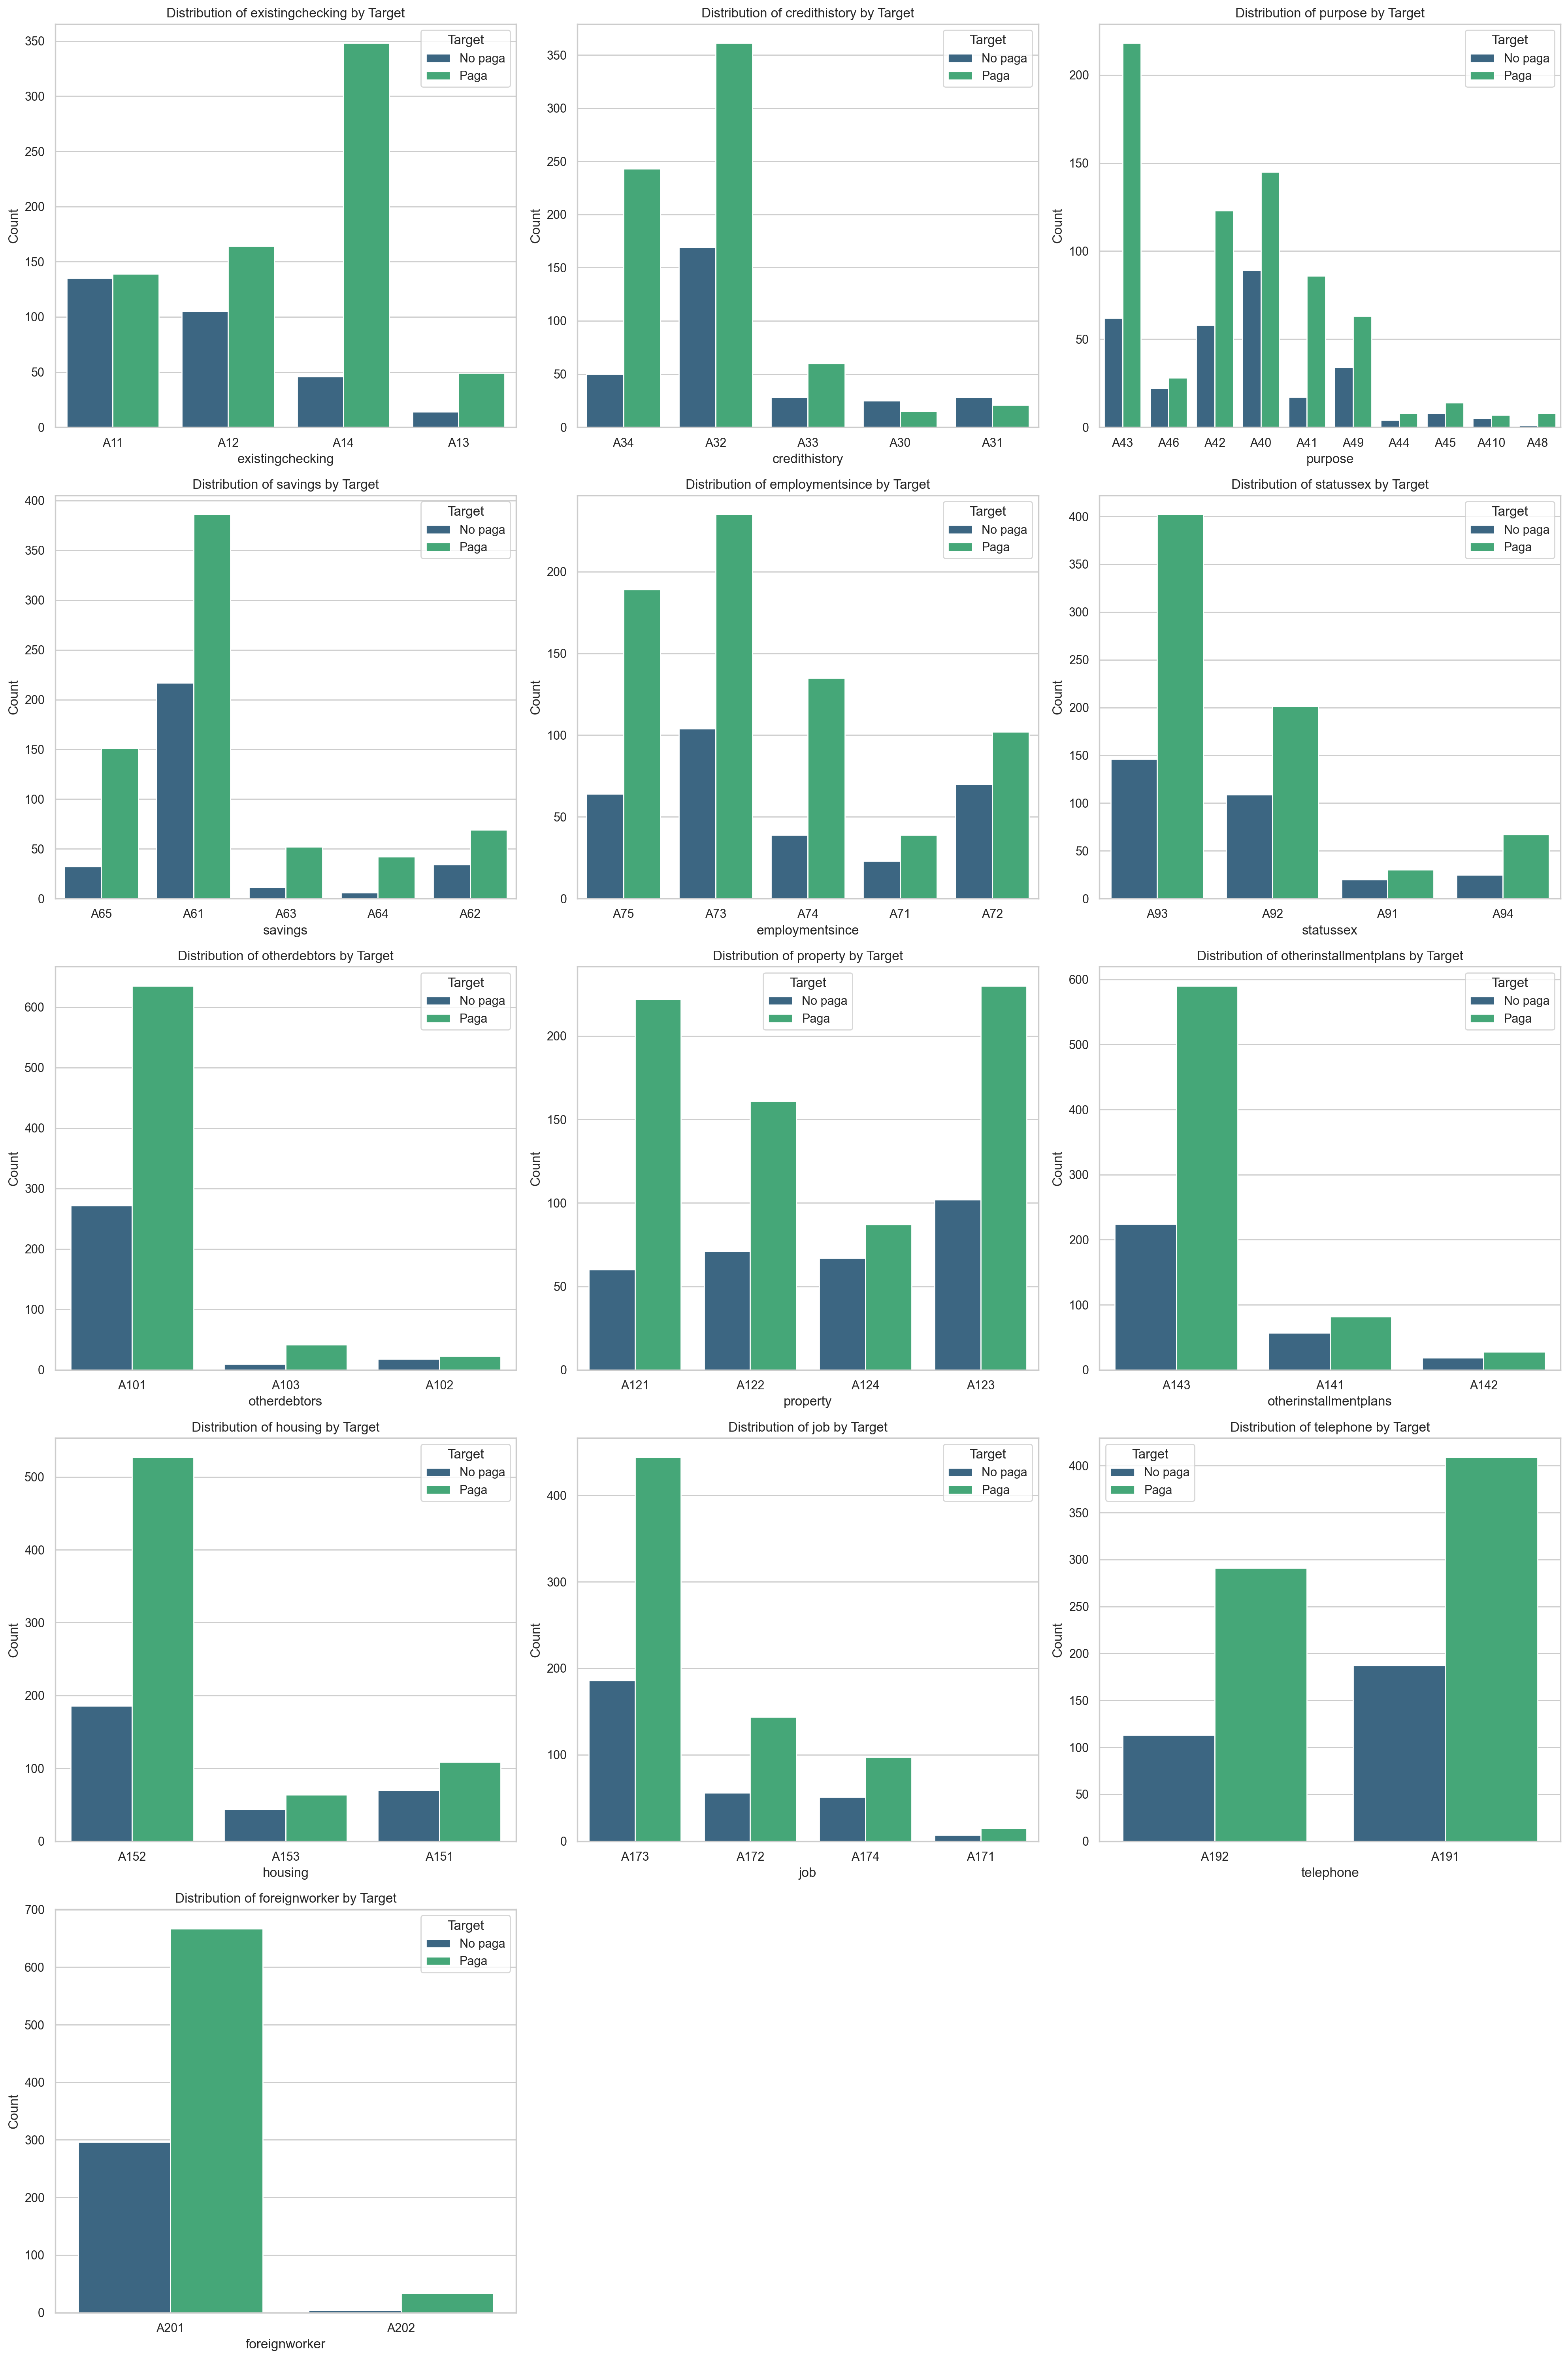

In [9]:
sns.set(style="whitegrid")

# Variables categóricas
categorical_vars = ['existingchecking', 'credithistory', 'purpose', 'savings',
                    'employmentsince', 'statussex', 'otherdebtors', 'property',
                    'otherinstallmentplans', 'housing', 'job', 'telephone', 'foreignworker']

# Gráfico de barras agrupadas por Target para cada variable categórica
plt.figure(figsize=(20, 30))  # Ajusta el tamaño de la figura según sea necesario

for i, var in enumerate(categorical_vars):
    plt.subplot(5, 3, i+1)  # Ajusta filas y columnas según sea necesario
    sns.countplot(data=data, x=var, hue='target', palette='viridis')
    plt.title(f'Distribution of {var} by Target')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.legend(title='Target', labels=['No paga', 'Paga'])

plt.tight_layout()
plt.show()

Concluiones comparadas:
1. A11 como ceuntas en 0 para los que no pagan (sin dinero)
2. A40 (auto nuevo) como purpose de los que no pagan.
3. A61 (<100) en cuenta de ahorros los que no pagan.
4. A101 mayoria de los que no pagan no poseen deudor/garante.


# 2. Realice una preparación y preprocesado de los datos
---

Consigna: analice nulos, outliers, codifique de forma adecuado las variables categóricas, analice el desbalanceo de clases, etc.

(*) En el Inciso 1. vimos que no poseíamos valores nulos, por lo que no tenemos tratamiento alguno.

### Manejo de Outliers

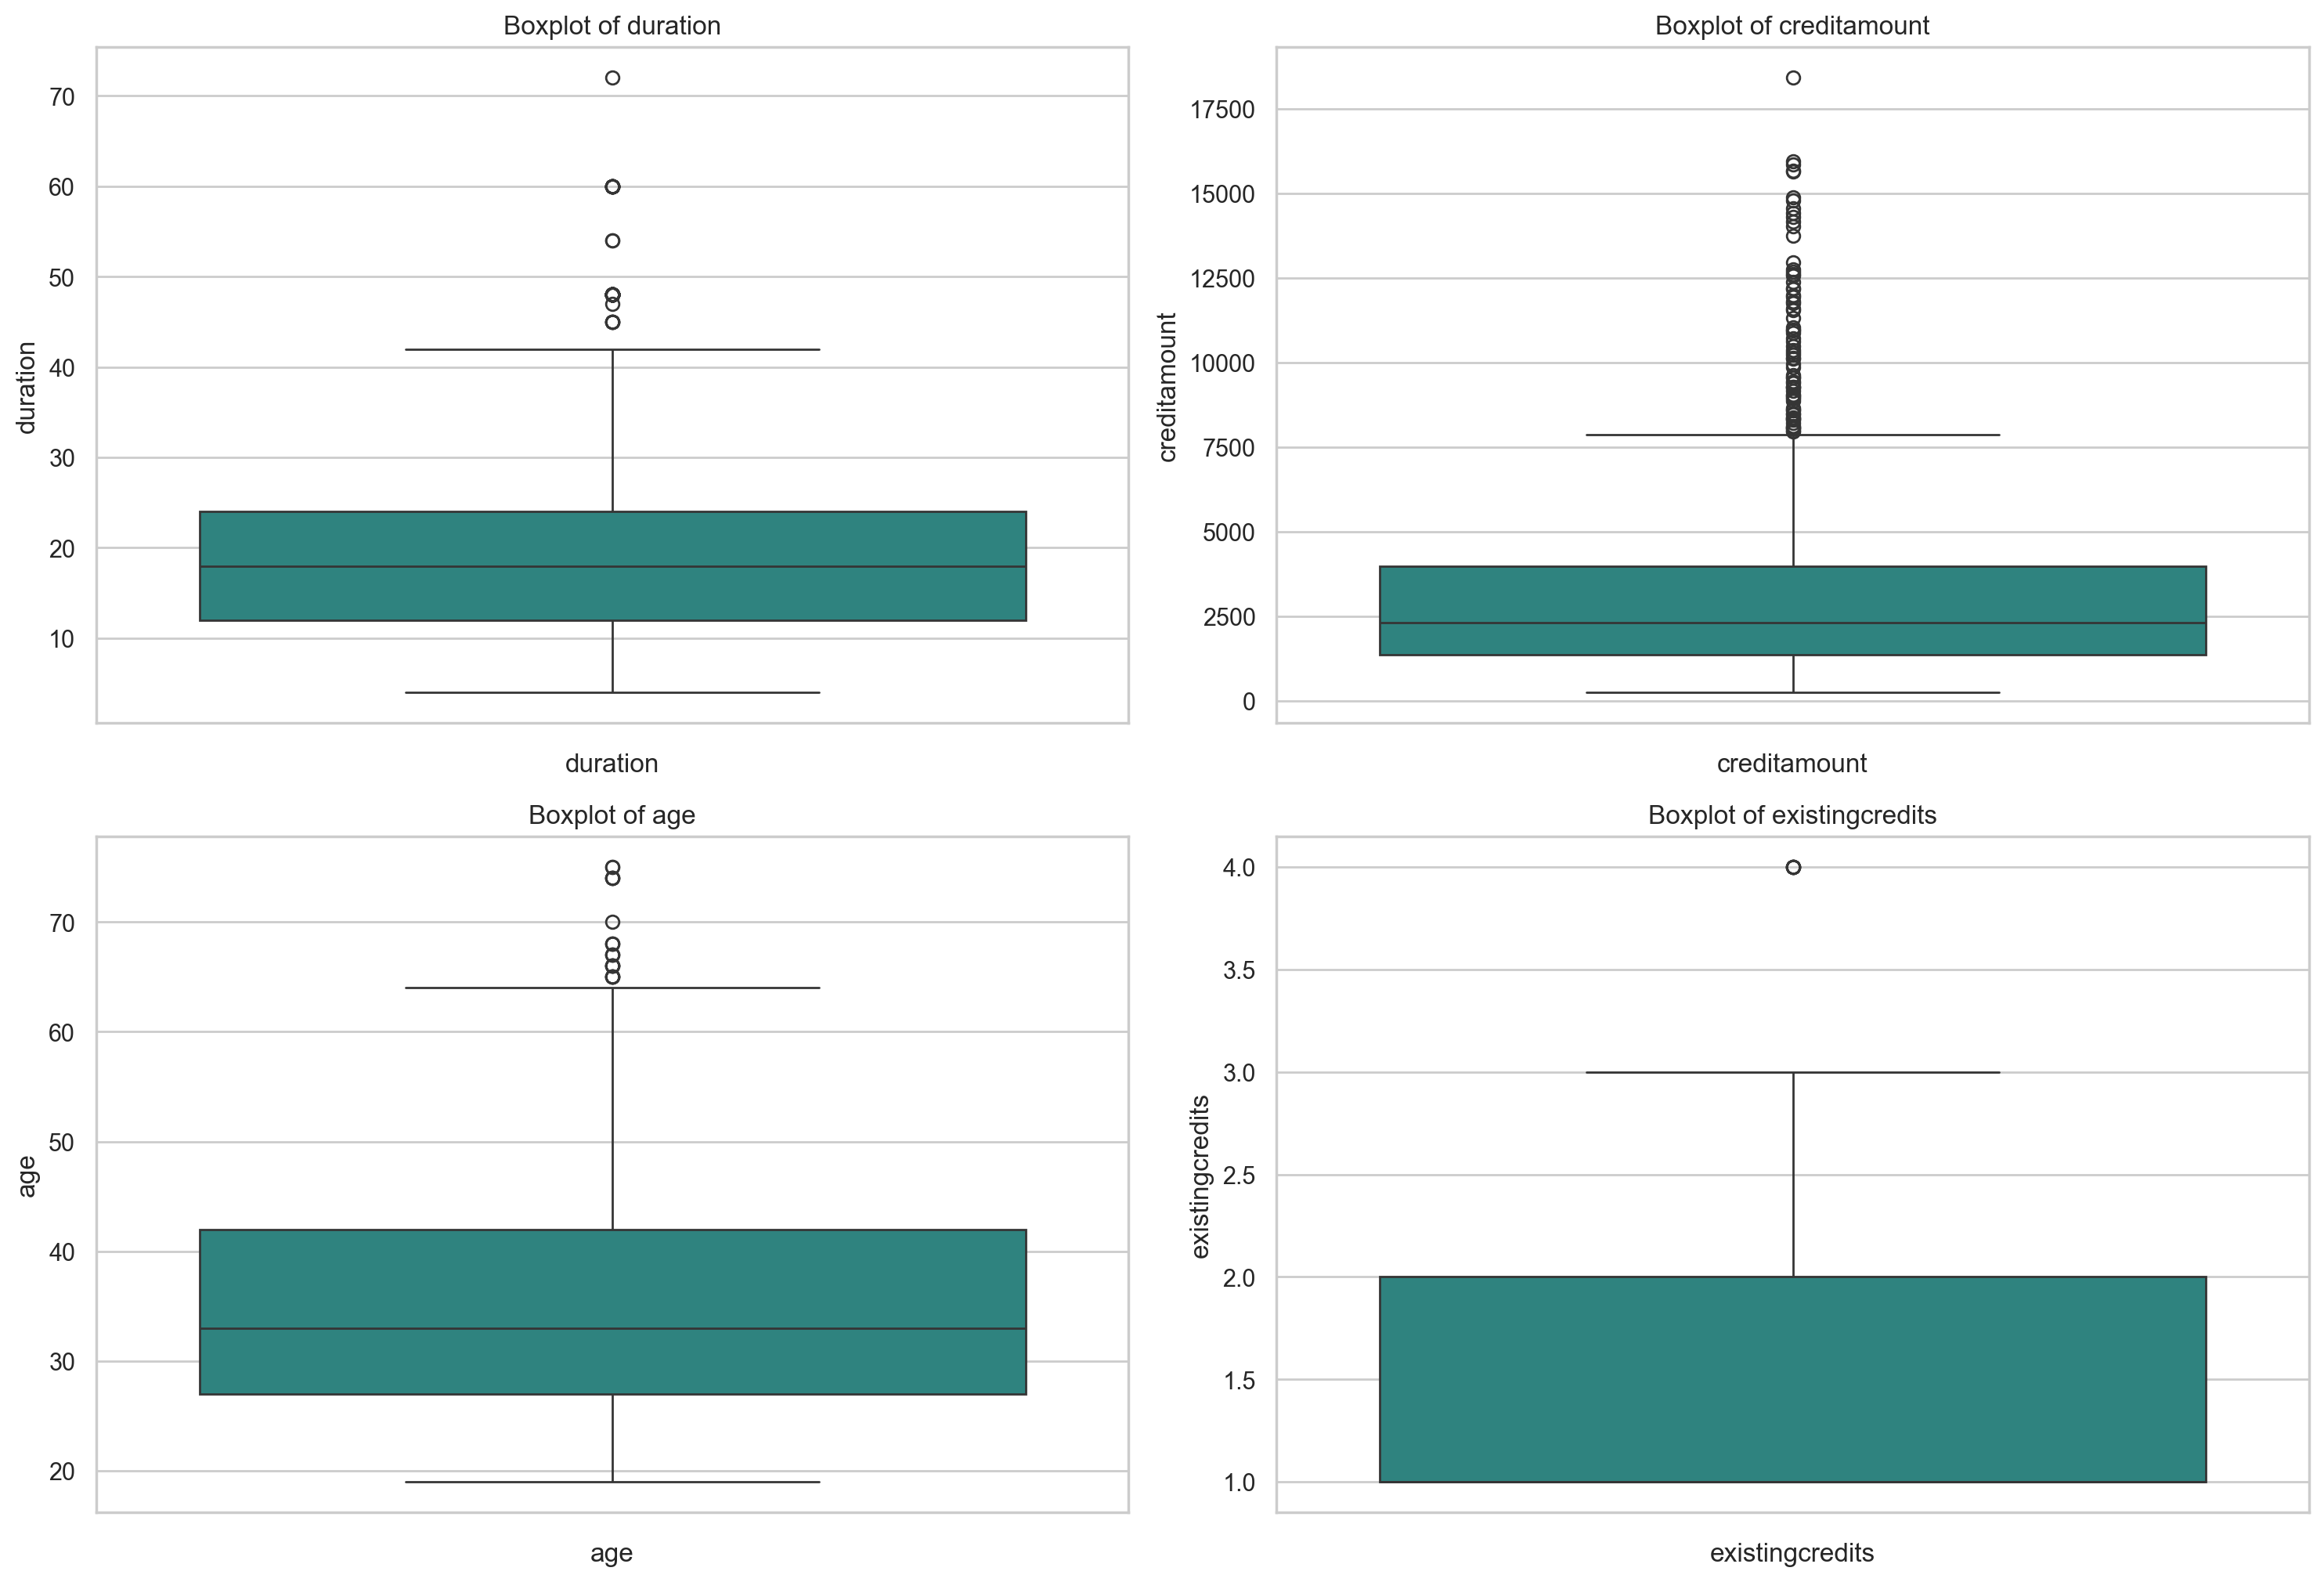

In [10]:
numeric_vars = ['duration', 'creditamount','age', 'existingcredits']

plt.figure(figsize=(15, 20))

for i, var in enumerate(numeric_vars):
    plt.subplot(4, 2, i+1) 
    sns.boxplot(data=data, y=var, palette='viridis')
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)

plt.tight_layout()
plt.show()

Conclusiones Boxplot:
- Los outliers de edad no presentan mayor conflicto ya que tenemos clientes entre 70-80 años de edad. Decido dejarlo.
- Los de Existingcredits, al ser una escala del 1-4 no veo conflicto.
- Los de outliers de creditamount y duration porque segun la distribucion que vimos anteriormente hay una gran concentracion  en el sector izquierdo del grafico para ambas pero eso no quiere decir que los valores que aca se consideren fuera de la normal sean efectivamente una anomalía. Una duracion de pago de prestamo de 60 meses np es algo fuera de lo normal a mi parecer. Lo mismo considero con el monto del credito, si bien hay un gran porcentaje en creditos de media 2500, podrian existir montos mas altos sin ser considerados fuera de lo normal en este caso. En el caso que considere hasta el bigote, 7500 como monto, deberia dejar de lado y darle tratamiento de outlier a 86 registros en un dataset de 1000, siendo un 8.6% de mi muestra.

In [11]:
df_filtrado = data[data['creditamount'] > 7500]
df_filtrado.count()

existingchecking         86
duration                 86
credithistory            86
purpose                  86
creditamount             86
savings                  86
employmentsince          86
installmentrate          86
statussex                86
otherdebtors             86
residencesince           86
property                 86
age                      86
otherinstallmentplans    86
housing                  86
existingcredits          86
job                      86
peopleliable             86
telephone                86
foreignworker            86
target                   86
dtype: int64

### Codificacion de variables categoricas

In [12]:
cat_cols = data.select_dtypes(include=['object']).columns
cat_cols

Index(['existingchecking', 'credithistory', 'purpose', 'savings',
       'employmentsince', 'statussex', 'otherdebtors', 'property',
       'otherinstallmentplans', 'housing', 'job', 'telephone',
       'foreignworker'],
      dtype='object')

In [13]:
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(data, cat_vars):
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_data = pd.DataFrame()

    for var in cat_vars:
        encoded_var = ohe.fit_transform(data[var].values.reshape(-1,1))
        cols = [var + '_' + str(category) for category in ohe.categories_[0]]
        encoded_var_df = pd.DataFrame(encoded_var, columns=cols)
        encoded_data = pd.concat([encoded_data, encoded_var_df], axis=1)
    data = data.drop(columns=cat_vars)
    data = pd.concat([data, encoded_data], axis=1)
    return data

In [14]:
data_encoded = onehot_encode(data, cat_cols)
data_encoded

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,target,existingchecking_A11,existingchecking_A12,...,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreignworker_A201,foreignworker_A202
0,6,1169,4,4,67,2,1,1,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,48,5951,2,2,22,1,1,0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,12,2096,2,3,49,1,2,1,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,42,7882,2,4,45,1,2,1,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,24,4870,3,4,53,2,2,0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,30,3857,4,4,40,1,1,1,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,12,804,4,4,38,1,1,1,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,45,1845,4,4,23,1,1,0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


### Desbalanceo de clases

**¿A que nos referimos?**
En aprendizaje automático, el desbalanceo de clases ocurre cuando las diferentes clases en el conjunto de datos no están representadas de manera equitativa. Por ejemplo, en un problema de clasificación binaria, si solo el 5% de los ejemplos pertenecen a la clase positiva y el 95% a la clase negativa, se dice que hay un desbalanceo de clases.

Este desbalanceo puede afectar negativamente el rendimiento del modelo, ya que puede llevar a que el modelo esté sesgado hacia la clase mayoritaria y tenga un desempeño deficiente en la clase minoritaria. Algunos problemas que pueden surgir incluyen:

1. Rendimiento sesgado: El modelo puede predecir en su mayoría la clase mayoritaria, ignorando la minoritaria.
2. Métricas engañosas: Métricas como la precisión global pueden ser engañosas si la clase minoritaria es muy pequeña.
3. Sobreajuste: El modelo puede sobreajustarse a la clase mayoritaria, reduciendo su capacidad para generalizar.

Para manejar el desbalanceo de clases, se pueden usar técnicas como:

- Sobremuestreo: Aumentar el número de ejemplos en la clase minoritaria.
- Submuestreo: Reducir el número de ejemplos en la clase mayoritaria.
- Generación de datos sintéticos: Crear nuevos ejemplos para la clase minoritaria usando técnicas como SMOTE (Synthetic Minority Over-sampling Technique).
- Uso de algoritmos de penalización: Ajustar los pesos de las clases para que el modelo preste más atención a la clase minoritaria.
- Evaluación con métricas adecuadas: Usar métricas como la precisión, el recall, el F1-score o la curva ROC-AUC, que son más informativas en el contexto de desbalanceo de clases.

In [15]:
data["target"].value_counts()

1    700
0    300
Name: target, dtype: int64

Podemos observar que de los 1000 registros 700 (70%) pertenecen a una clase y 300 (30%) al otro, estando desbalanceadas.

# 3. Compare las prestaciones en un conjunto de test de los siguientes clasificadores en términos de área bajo la curva ROC (AUC-ROC) y F1-score
--- 

Compare las prestaciones en un conjunto de test de los siguientes clasificadores en términos de área bajo la curva ROC (AUC-ROC) y F1-score: 

- Regresión Logística con regularización L2, validando el parámetro $C$ de regularización.
- Random Forest validando tanto el número de estimadores y el máximo número de hojas.
- XGBoost validando el el número de estimadores, la máxima profundidad del arbol y learning_rate.
- Elija algún otro algoritmo si lo considera necesario

Ademas:
-    En todos los casos, valide el número de variables a la entrada usando el criterio de información mútua y seleccione rangos de validación adecuados para cada hiperparámetro utilizando Gridsearch y Cross Validation. 
-   Y utilice Pipeline de sklearn para garantizar la ejecución ordenada de los distintos pasos

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import scipy.stats as st
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

Divido en Train y Test 

(el parámetro "stratify" se utiliza para asegurar que la división entre el conjunto de entrenamiento y el de prueba mantenga la proporción de clases de la variable objetivo en ambos conjuntos. Esto es especialmente útil en problemas de clasificación con clases desbalanceadas.)

In [38]:
y = data_encoded['target']
X = data_encoded.loc[:, data_encoded.columns != 'target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=99)

In [39]:
def model_trial(model, parameters, smote = False, ros = False):

  np.random.seed(42)
  kf = StratifiedKFold(n_splits=5, shuffle=False)

  # pipeline 
  if smote:
    pipe = Pipeline(steps=[('smote', SMOTE(random_state=42)), ('standardscaler', StandardScaler()), ('selector', SelectKBest(f_classif)), ('classifier', model)])
  else:
    pipe = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(f_classif)), ('classifier', model)])

  # validación cruzada Gridsearch
  grid = GridSearchCV(pipe, parameters, cv=kf, scoring='precision')
  grid.fit(X_train, y_train)

  best_params = grid.best_params_
  best_model = grid.best_estimator_
  best_score = grid.best_score_

  # Evaluamos el modelo en train

  y_train_pred = best_model.predict(X_train)
  auc_roc_train = roc_auc_score(y_train, y_train_pred)
  f1_train = f1_score(y_train, y_train_pred)
  precision_train = precision_score(y_train, y_train_pred)

  # Evaluamos el modelo en test
  y_pred = best_model.predict(X_test)
  auc_roc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  print(f"Mejores parámetros: {best_params}")
  print(f"AUC-ROC Train: {auc_roc_train} and AUC-ROC Test: {auc_roc}")
  print(f"F1-Score Train: {f1_train} and F1-Score Test: {f1}")
  print(f"Precision-Score Train: {precision_train} and Precision-Score Test: {precision}")

  return precision, auc_roc, f1, best_model, precision_train, auc_roc_train, f1_train

1. Modelo de Regresion Logistica

In [42]:
model = LogisticRegression(penalty='l2', random_state = 99)
parameters = {
    'selector__k': [10, 20, 30, 40],
    'classifier__C': [10**x for x in range(-5, 3)]
}

lr = model_trial(model, parameters)
lr

Mejores parámetros: {'classifier__C': 1, 'selector__k': 40}
AUC-ROC Train: 0.7220238095238096 and AUC-ROC Test: 0.7130952380952381
F1-Score Train: 0.8583617747440273 and F1-Score Test: 0.8532423208191127
Precision-Score Train: 0.8218954248366013 and Precision-Score Test: 0.8169934640522876


(0.8169934640522876,
 0.7130952380952381,
 0.8532423208191127,
 Pipeline(steps=[('scaler', StandardScaler()), ('selector', SelectKBest(k=40)),
                 ('classifier', LogisticRegression(C=1, random_state=99))]),
 0.8218954248366013,
 0.7220238095238096,
 0.8583617747440273)

2. Modelo de Random Forest

In [41]:
model = RandomForestClassifier(random_state = 99)
parameters = {
    'selector__k': [10, 20, 30, 40],
    'classifier__n_estimators': [200, 300, 400],
    'classifier__max_leaf_nodes': [2,4,5,10,20,50]
}
rf = model_trial(model, parameters)
rf

Mejores parámetros: {'classifier__max_leaf_nodes': 50, 'classifier__n_estimators': 200, 'selector__k': 10}
AUC-ROC Train: 0.7934523809523809 and AUC-ROC Test: 0.6702380952380953
F1-Score Train: 0.9077181208053692 and F1-Score Test: 0.8438538205980066
Precision-Score Train: 0.8560126582278481 and Precision-Score Test: 0.7888198757763976


(0.7888198757763976,
 0.6702380952380953,
 0.8438538205980066,
 Pipeline(steps=[('scaler', StandardScaler()), ('selector', SelectKBest()),
                 ('classifier',
                  RandomForestClassifier(max_leaf_nodes=50, n_estimators=200,
                                         random_state=99))]),
 0.8560126582278481,
 0.7934523809523809,
 0.9077181208053692)

3. Modelo XGBoost

In [43]:
model = XGBClassifier()
parameters = {
    'selector__k': [10, 20, 30, 40],
    'classifier__n_estimators': [10, 50, 100, 200, 300],
    'classifier__max_depth': [2,4,5,10,20,50],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}
xgb = model_trial(model, parameters)
xgb

Mejores parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'selector__k': 40}
AUC-ROC Train: 0.9916666666666666 and AUC-ROC Test: 0.6821428571428572
F1-Score Train: 0.9964412811387899 and F1-Score Test: 0.8316151202749141
Precision-Score Train: 0.9929078014184397 and Precision-Score Test: 0.8013245033112583


(0.8013245033112583,
 0.6821428571428572,
 0.8316151202749141,
 Pipeline(steps=[('scaler', StandardScaler()), ('selector', SelectKBest(k=40)),
                 ('classifier',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.1,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=5, max_leaves=None,
                                min_c

In [44]:
df_funciones = pd.DataFrame()
df_funciones["metodo"] = ["regresion logistica", "random forest", "xgboost"]
df_funciones["auc_roc"] = [lr[1] , rf[1] , xgb[1]]
df_funciones["f1_score"] = [lr[2] , rf[2] , xgb[2]]
df_funciones["precision_score"] = [lr[0] , rf[0] , xgb[0]]
df_funciones["auc_roc_train"] = [lr[5] , rf[5] , xgb[5]]
df_funciones["f1_score_train"] = [lr[6] , rf[6] , xgb[6]]
df_funciones["precision_score_train"] = [lr[4] , rf[4] , xgb[4]]

print(df_funciones)

                metodo   auc_roc  f1_score  precision_score  auc_roc_train  \
0  regresion logistica  0.713095  0.853242         0.816993       0.722024   
1        random forest  0.670238  0.843854         0.788820       0.793452   
2              xgboost  0.682143  0.831615         0.801325       0.991667   

   f1_score_train  precision_score_train  
0        0.858362               0.821895  
1        0.907718               0.856013  
2        0.996441               0.992908  


### Si Balanceamos elijo SMOTE

1. Modelo de Regresion Logistica con SMOTE

In [25]:
model = LogisticRegression(penalty='l2', random_state = 99)
parameters = {
    'selector__k': [10, 20, 30, 40],
    'classifier__C': [10**x for x in range(-5, 3)]
}

lr_smote = model_trial(model, parameters, smote = True)
lr_smote

Mejores parámetros: {'classifier__C': 1e-05, 'selector__k': 40}
AUC-ROC Train: 0.7645833333333334 and AUC-ROC Test: 0.7047619047619048
F1-Score Train: 0.8015794669299111 and F1-Score Test: 0.787878787878788
Precision-Score Train: 0.8962472406181016 and Precision-Score Test: 0.8387096774193549


(0.8387096774193549,
 0.7047619047619048,
 0.787878787878788,
 Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('standardscaler', StandardScaler()),
                 ('selector', SelectKBest(k=40)),
                 ('classifier', LogisticRegression(C=1e-05, random_state=99))]),
 0.8962472406181016,
 0.7645833333333334,
 0.8015794669299111)

2. Modelo de Random Forest con SMOTE

In [26]:
model = RandomForestClassifier(random_state = 99)
parameters = {
    'selector__k': [10, 20, 30, 40],
    'classifier__n_estimators': [200, 300, 400],
    'classifier__max_leaf_nodes': [2,4,5,10,20,50]}
rf_smote = model_trial(model, parameters, smote = True)
rf_smote

Mejores parámetros: {'classifier__max_leaf_nodes': 2, 'classifier__n_estimators': 200, 'selector__k': 30}
AUC-ROC Train: 0.7029761904761905 and AUC-ROC Test: 0.6761904761904763
F1-Score Train: 0.7736943907156673 and F1-Score Test: 0.75
Precision-Score Train: 0.8438818565400844 and Precision-Score Test: 0.8275862068965517


(0.8275862068965517,
 0.6761904761904763,
 0.75,
 Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('standardscaler', StandardScaler()),
                 ('selector', SelectKBest(k=30)),
                 ('classifier',
                  RandomForestClassifier(max_leaf_nodes=2, n_estimators=200,
                                         random_state=99))]),
 0.8438818565400844,
 0.7029761904761905,
 0.7736943907156673)

3. Modelo XGBoost CON SMOTE

In [27]:
model = XGBClassifier()
parameters = {
    'selector__k': [10, 20, 30, 40],
    'classifier__n_estimators': [10, 50, 100, 200, 300],
    'classifier__max_depth': [2, 4,5,10,20,50],
    'classifier__learning_rate': [0.1, 0.01, 0.001]}
xgb_smote = model_trial(model, parameters, smote = True)
xgb_smote

Mejores parámetros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__n_estimators': 10, 'selector__k': 40}
AUC-ROC Train: 0.7020833333333333 and AUC-ROC Test: 0.7035714285714286
F1-Score Train: 0.726895119418484 and F1-Score Test: 0.7172995780590717
Precision-Score Train: 0.8684863523573201 and Precision-Score Test: 0.8762886597938144


(0.8762886597938144,
 0.7035714285714286,
 0.7172995780590717,
 Pipeline(steps=[('smote', SMOTE(random_state=42)),
                 ('standardscaler', StandardScaler()),
                 ('selector', SelectKBest(k=40)),
                 ('classifier',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=...e, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.1,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                ma

In [45]:
smote_rows = [
    {"metodo": f"SMOTE {m}", "auc_roc": sm[1], "f1_score": sm[2], 
     "precision_score": sm[0], "auc_roc_train": sm[5], 
     "f1_score_train": sm[6], "precision_score_train": sm[4]}
    for m, sm in zip(["rl", "rf", "xgb"], [lr_smote, rf_smote, xgb_smote])
]

df_funciones = df_funciones.append(smote_rows, ignore_index=True)

print(df_funciones)

                metodo   auc_roc  f1_score  precision_score  auc_roc_train  \
0  regresion logistica  0.713095  0.853242         0.816993       0.722024   
1        random forest  0.670238  0.843854         0.788820       0.793452   
2              xgboost  0.682143  0.831615         0.801325       0.991667   
3             SMOTE rl  0.704762  0.787879         0.838710       0.764583   
4             SMOTE rf  0.676190  0.750000         0.827586       0.702976   
5            SMOTE xgb  0.703571  0.717300         0.876289       0.702083   

   f1_score_train  precision_score_train  
0        0.858362               0.821895  
1        0.907718               0.856013  
2        0.996441               0.992908  
3        0.801579               0.896247  
4        0.773694               0.843882  
5        0.726895               0.868486  


# 4. Represente también en una única gráfica la curva ROC de los cuatro clasificadores.
---


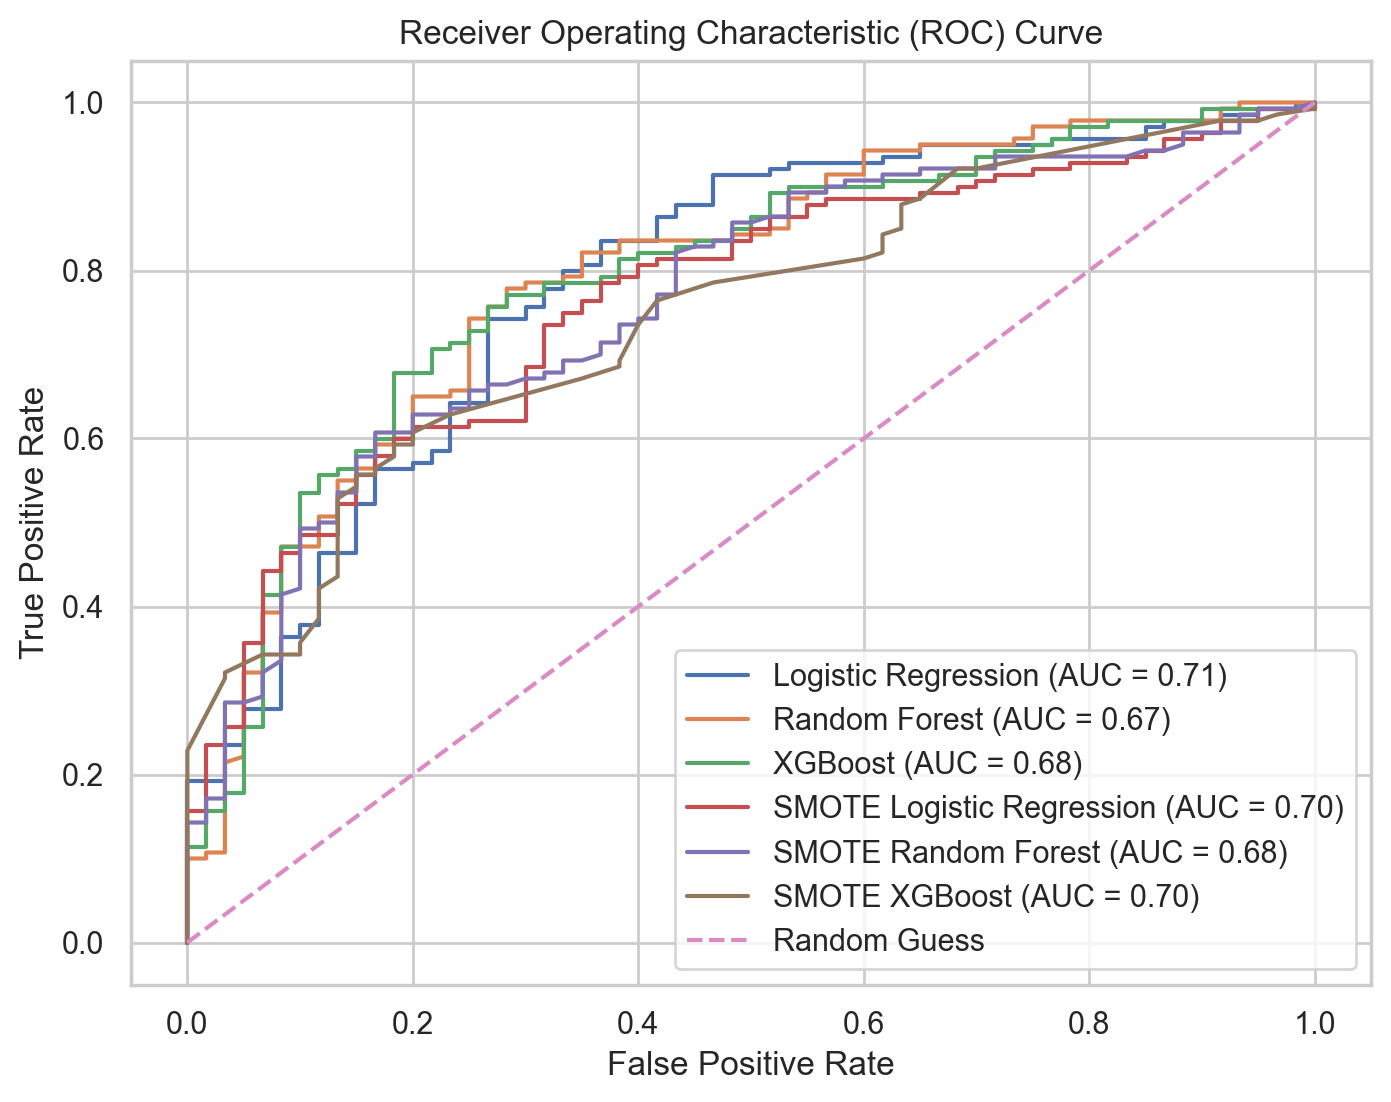

In [51]:
# probabilidades predichas
lr_prob = lr[3].predict_proba(X_test)[:, 1]
rf_prob = rf[3].predict_proba(X_test)[:, 1]
xgb_prob = xgb[3].predict_proba(X_test)[:, 1]

lr_smote_prob = lr_smote[3].predict_proba(X_test)[:, 1]
rf_smote_prob = rf_smote[3].predict_proba(X_test)[:, 1]
xgb_smote_prob = xgb_smote[3].predict_proba(X_test)[:, 1]

# tasas de verdaderos positivos y falsos positivos
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)

lr_smote_fpr, lr_smote_tpr, _ = roc_curve(y_test, lr_smote_prob)
rf_smote_fpr, rf_smote_tpr, _ = roc_curve(y_test, rf_smote_prob)
xgb_smote_fpr, xgb_smote_tpr, _ = roc_curve(y_test, xgb_smote_prob)

# curva ROC
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr[1]:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf[1]:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = { xgb[1]:.2f})')

plt.plot(lr_smote_fpr, lr_smote_tpr, label=f'SMOTE Logistic Regression (AUC = {lr_smote[1]:.2f})')
plt.plot(rf_smote_fpr, rf_smote_tpr, label=f'SMOTE Random Forest (AUC = {rf_smote[1]:.2f})')
plt.plot(xgb_smote_fpr, xgb_smote_tpr, label=f'SMOTE XGBoost (AUC = { xgb_smote[1]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# 5. Recomiende el mejor clasificador y explique su elección

# 
---

In [52]:
df_funciones.sort_values(by = "precision_score", ascending = False)

,metodo,auc_roc,f1_score,precision_score,auc_roc_train,f1_score_train,precision_score_train
5,SMOTE xgb,0.703571,0.717300,0.876289,0.702083,0.726895,0.868486
3,SMOTE rl,0.704762,0.787879,0.838710,0.764583,0.801579,0.896247
4,SMOTE rf,0.676190,0.750000,0.827586,0.702976,0.773694,0.843882
0,regresion logistica,0.713095,0.853242,0.816993,0.722024,0.858362,0.821895
2,xgboost,0.682143,0.831615,0.801325,0.991667,0.996441,0.992908
1,random forest,0.670238,0.843854,0.788820,0.793452,0.907718,0.856013


Basado en los resultados:

1. El AUC para los modelos varía entre 0.67 (Random Forest) y 0.71 (Regresión Logística). El AUC de los modelos con SMOTE también varía de manera limitada, siendo el más bajo el de Random Forest con SMOTE (0.67) y el más alto el de Regresión Logística con SMOTE (0.70).

2. El modelo con mayor precisión es SMOTE XGB con un valor de 0.87, seguido por Regresión Logística con SMOTE con una precisión de 0.84. El modelo XGBoost sin balanceo también muestra un buen desempeño con una precisión de 0.80.

3. Los modelos sin balanceo, como Regresión Logística y Random Forest, tienen los F1-Score más altos, con valores de 0.85 y 0.84 respectivamente, lo que indica un buen equilibrio entre precisión y recall. Sin embargo, los modelos con SMOTE también muestran resultados sólidos en F1, como el caso de SMOTE RL con un F1-Score de 0.79.

4. El overfitting es menos pronunciado en los modelos balanceados con SMOTE. Los modelos de SMOTE XGB y SMOTE RL presentan una diferencia mínima entre los resultados de entrenamiento y prueba. Por el contrario, el modelo XGBoost sin SMOTE muestra signos de overfitting con un AUC en el entrenamiento de 0.99 comparado con un 0.68 en el conjunto de prueba.

*Conclusión*: es recomendable el uso del modelo XGBoost con SMOTE, ya que logra un buen equilibrio entre precisión y recall, con un bajo riesgo de overfitting.